In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openml

plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['legend.labelcolor'] = 'black'

# What is going on in this EDA?
Here is what is going on step by step
- load up the dataset using OpenML API
- inspect the descriptive statistics of cont. variables and value counts of cat. variables
- pair plots, histograms, boxplots, scatterplots, and correlation matricies to get a sense of relationships
between variables
- I noticed that a couple of features were highly related so experimented with engineering new features that combined all of their information

# What was the verdict?
None of the columns required cleaning (the dataset was already cleaned when it was uploaded).  No outliers seemed to be problematic. height, normalized losses, stroke, compression-ratio, and bore got thrown out because they did not seem very informative.

City and highway mpg were incredibly related and also very informative on the price. decided to merge them by taking the arithmetic mean. The same also proved to be true about wheel base, curb weight, horsepower, width, length, and engine size. Taking the arithmetic mean of these features created a new feature with similar shape to the original features while also having a similar corelation to the target variable. These two new features also seemed somewhat normal in their distribution.

For model selection I decided on a random forest regressor. Although there seemed to be some clusters in some of the views, signifying that maybe a clustering algorithm could be used, I feel that clustering would prove more effective with data like vehicle type (sedan, SUV, truck, etc.) as well as brand (Toyota, Porsche, etc.). I also decided to one hot encode the lone categorical variable and standard scale the continuous ones.

In [2]:
# get the dataset first.
datasets = openml.datasets.list_datasets(output_format='dataframe')

In [3]:
datasets[datasets['name'] == 'auto_price']

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
195,195,auto_price,1,1,active,ARFF,NaN,6.0,NaN,0.0,16.0,159.0,0.0,0.0,15.0,1.0
745,745,auto_price,2,2,active,ARFF,105.0,6.0,54.0,2.0,16.0,159.0,0.0,0.0,14.0,2.0


In [4]:
dataset = openml.datasets.get_dataset(195)

In [5]:
df = dataset.get_data(dataset_format='dataframe')[0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          159 non-null    category
 1   normalized-losses  159 non-null    float64 
 2   wheel-base         159 non-null    float64 
 3   length             159 non-null    float64 
 4   width              159 non-null    float64 
 5   height             159 non-null    float64 
 6   curb-weight        159 non-null    float64 
 7   engine-size        159 non-null    float64 
 8   bore               159 non-null    float64 
 9   stroke             159 non-null    float64 
 10  compression-ratio  159 non-null    float64 
 11  horsepower         159 non-null    uint8   
 12  peak-rpm           159 non-null    float64 
 13  city-mpg           159 non-null    uint8   
 14  highway-mpg        159 non-null    uint8   
 15  price              159 non-null    float64 
dtypes: categ

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
normalized-losses,159.0,121.132075,35.651285,65.000000,94.000,113.000000,148.00,256.00
wheel-base,159.0,98.264151,5.167416,86.600000,94.500,96.900000,100.80,115.60
length,159.0,172.413836,11.523177,141.100000,165.650,172.400000,177.80,202.60
width,159.0,65.607547,1.947883,60.300000,64.000,65.400000,66.50,71.70
height,159.0,53.899371,2.268761,49.400000,52.250,54.100000,55.50,59.80
curb-weight,159.0,2461.138365,481.941321,1488.000000,2065.500,2340.000000,2809.50,4066.00
engine-size,159.0,119.226415,30.460791,61.000000,97.000,110.000000,135.00,258.00
bore,159.0,3.300126,0.267336,2.540000,3.050,3.270000,3.56,3.94
stroke,159.0,3.236352,0.294888,2.070000,3.105,3.270000,3.41,4.17
compression-ratio,159.0,10.161132,3.889475,7.000000,8.700,9.000000,9.40,23.00


In [8]:
df['symboling'].value_counts()

0     48
1     46
2     29
-1    20
3     13
-2     3
-3     0
Name: symboling, dtype: int64

First lets check the distributions of each variable.

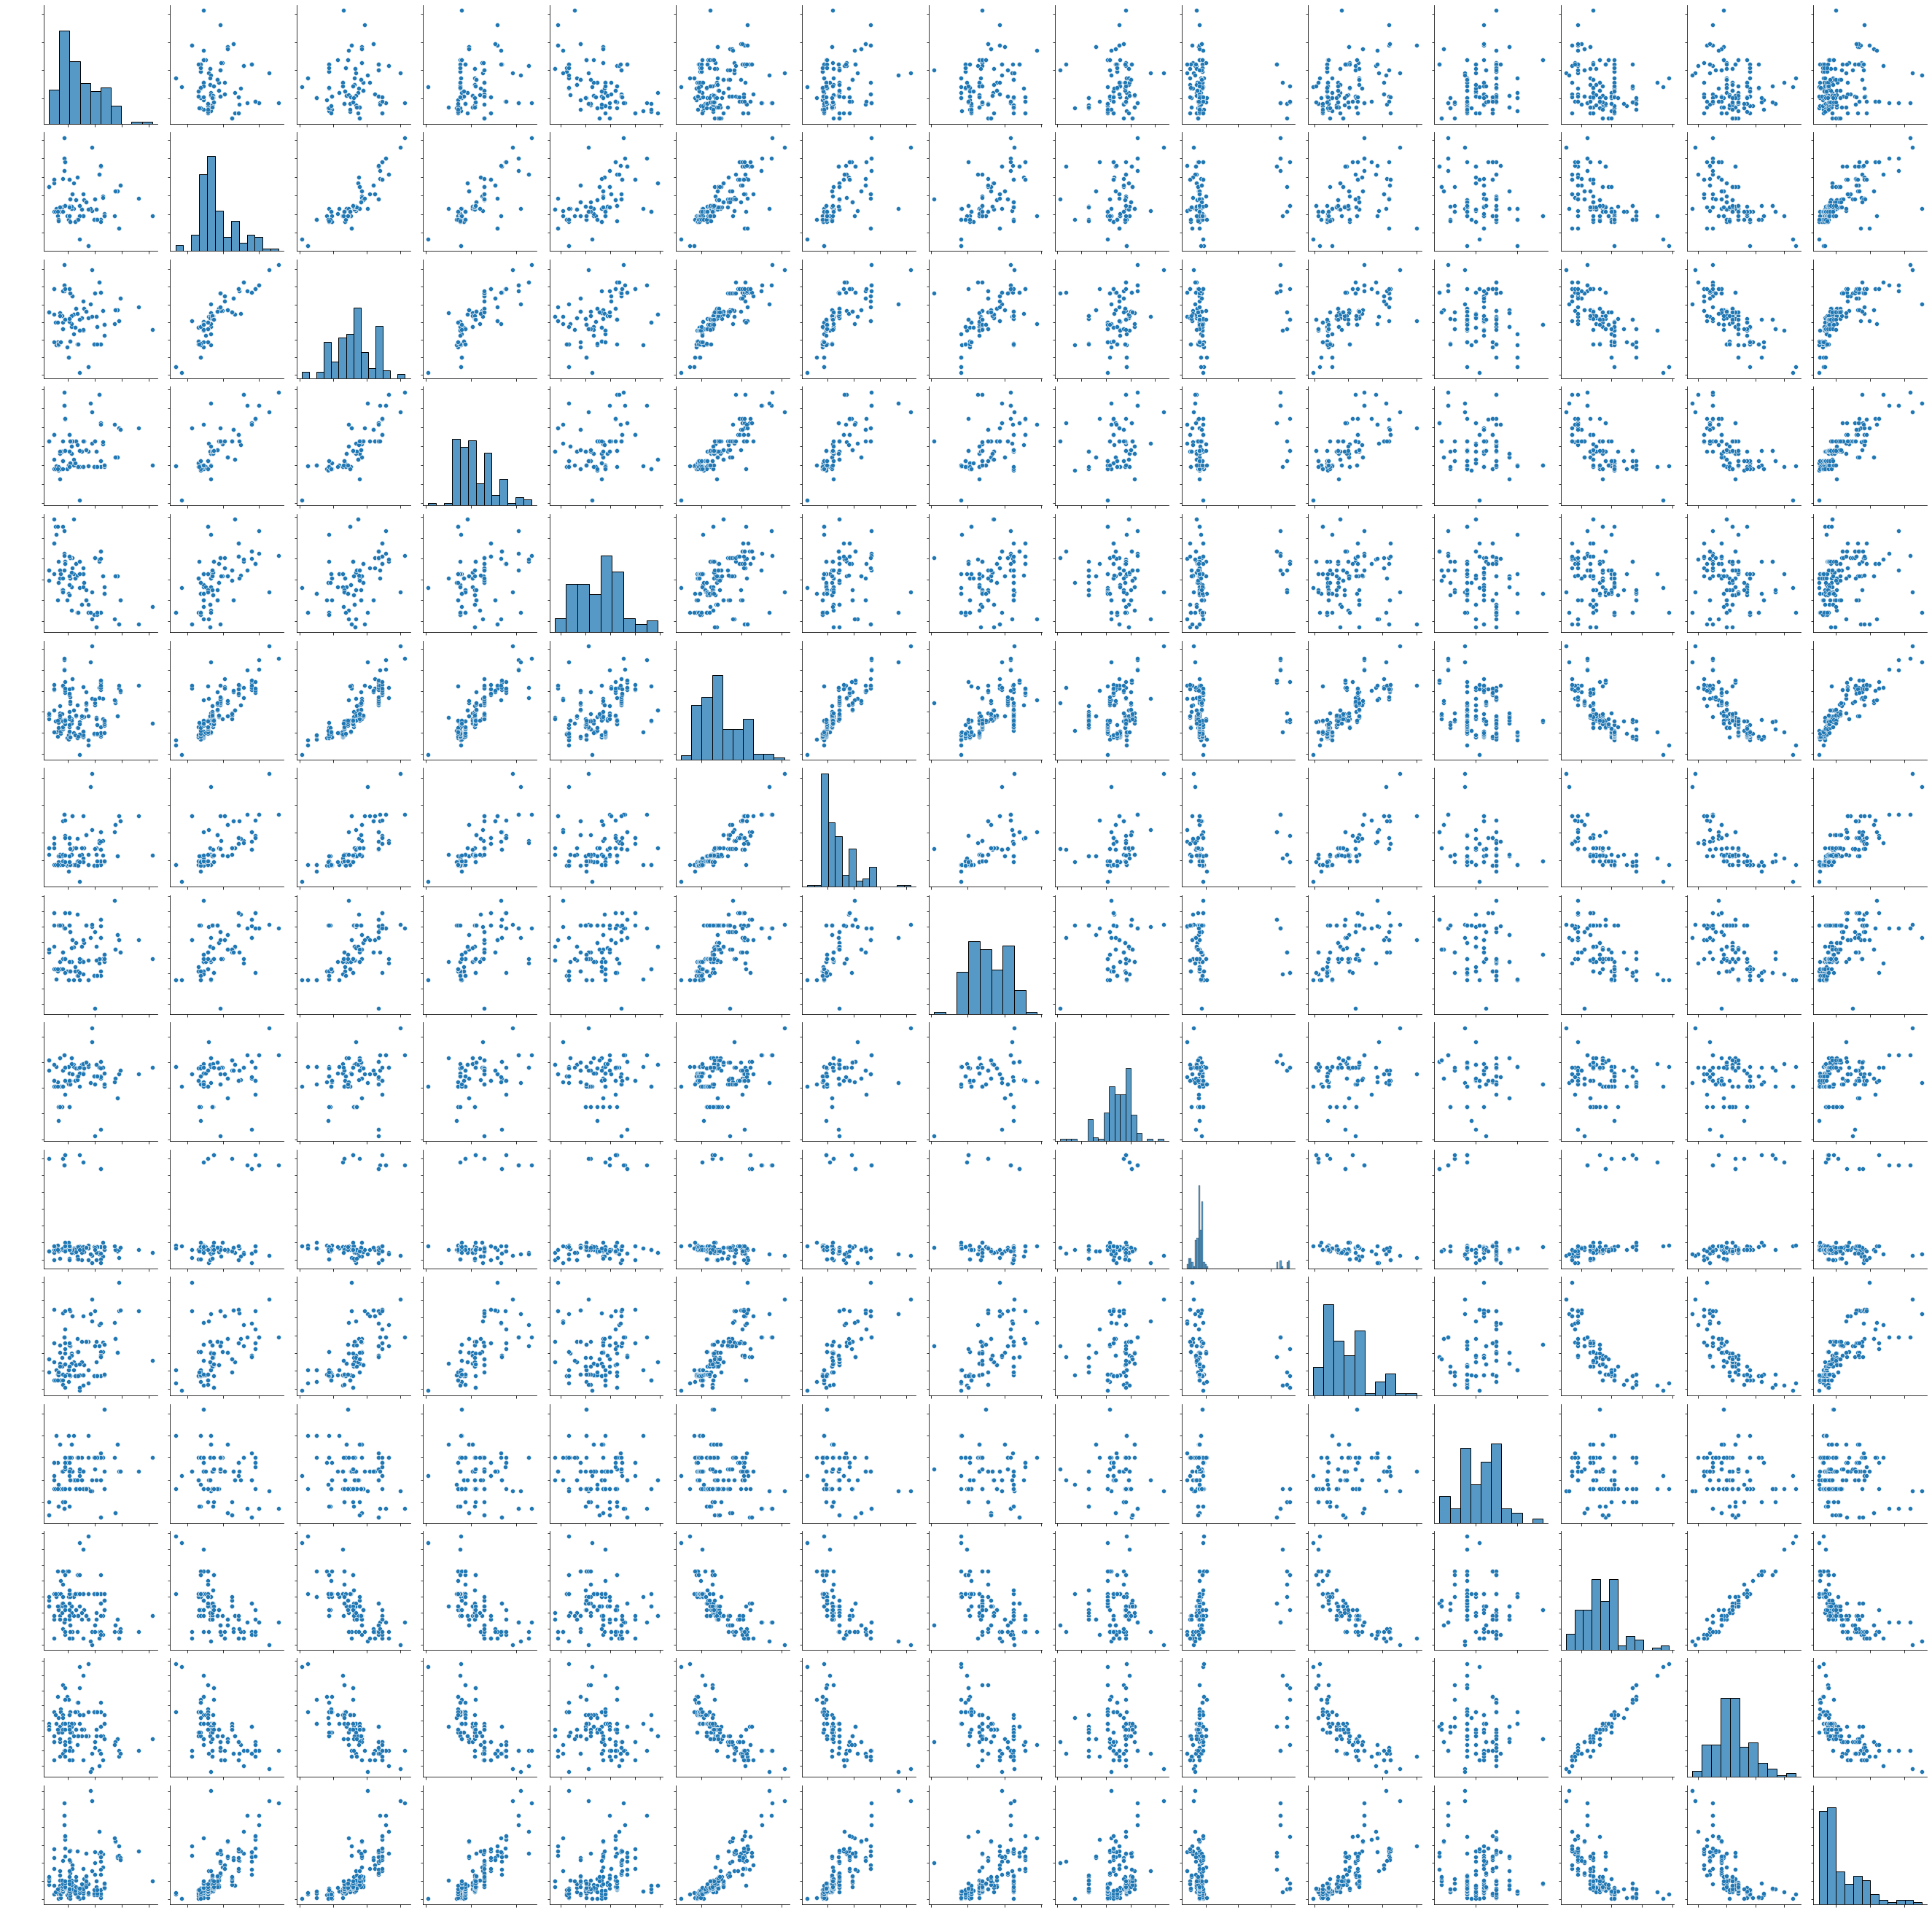

In [9]:
sns.pairplot(df)

So we can see a few things from the scatterplots and the correlation map:
- size mattters: length, width, weheel-base, curb-weight all have huge impacts.
- speed matters but not the way we would think. horsepower is important but not necessarily bore.
- mpg actaully causes prices to be lower... interestingly.
Some features that are highly correlated with one another:
- the sizes length, width, wheel-base, engine-size, curb-weight.

In [10]:
df.corr().style.background_gradient(cmap='viridis')

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
normalized-losses,1.000000,-0.060086,0.035541,0.109726,-0.413702,0.125858,0.207820,-0.031558,0.063330,-0.127259,0.290511,0.237697,-0.235523,-0.188564,0.202761
wheel-base,-0.060086,1.000000,0.871534,0.814991,0.555767,0.810181,0.649206,0.578159,0.167449,0.291431,0.516948,-0.289234,-0.580657,-0.611750,0.734419
length,0.035541,0.871534,1.000000,0.838338,0.499251,0.871291,0.725953,0.646318,0.121073,0.184814,0.672063,-0.234074,-0.724544,-0.724599,0.760952
width,0.109726,0.814991,0.838338,1.000000,0.292706,0.870595,0.779253,0.572554,0.196619,0.258752,0.681872,-0.232216,-0.666684,-0.693339,0.843371
height,-0.413702,0.555767,0.499251,0.292706,1.000000,0.367052,0.111083,0.254836,-0.091313,0.233308,0.034317,-0.245864,-0.199737,-0.226136,0.244836
curb-weight,0.125858,0.810181,0.871291,0.870595,0.367052,1.000000,0.888626,0.645792,0.173844,0.224724,0.790095,-0.259988,-0.762155,-0.789338,0.893639
engine-size,0.207820,0.649206,0.725953,0.779253,0.111083,0.888626,1.000000,0.595737,0.299683,0.141097,0.812073,-0.284686,-0.699139,-0.714095,0.841496
bore,-0.031558,0.578159,0.646318,0.572554,0.254836,0.645792,0.595737,1.000000,-0.102581,0.015119,0.560239,-0.312269,-0.590440,-0.590850,0.533890
stroke,0.063330,0.167449,0.121073,0.196619,-0.091313,0.173844,0.299683,-0.102581,1.000000,0.243587,0.148804,-0.011312,-0.020055,-0.012934,0.160664
compression-ratio,-0.127259,0.291431,0.184814,0.258752,0.233308,0.224724,0.141097,0.015119,0.243587,1.000000,-0.162305,-0.416769,0.278332,0.221483,0.209361


lets get a close look at those histograms. most of these look fairly normal. normalized-losses might be poisson and so might price?  compression ratio looks weird but that might be something we nix. lets look at compression ratio vs. price.

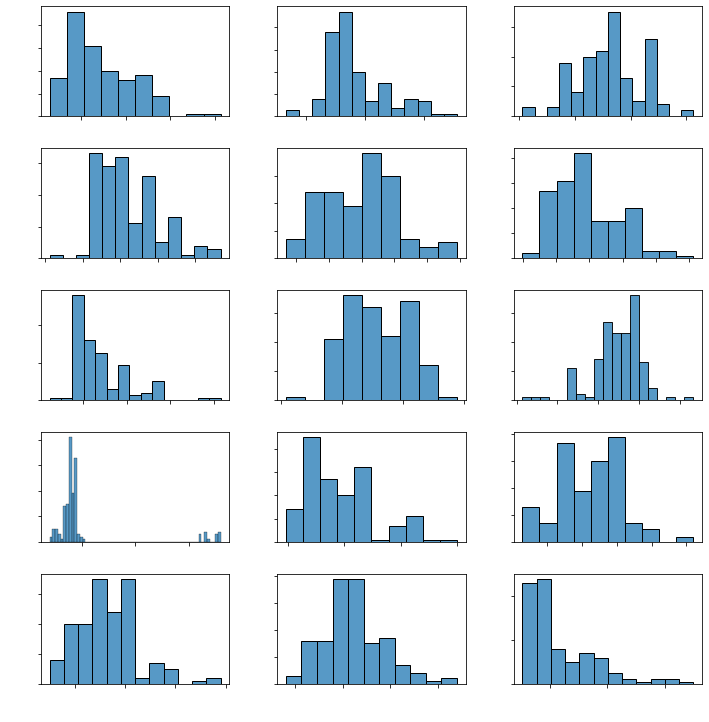

In [11]:
fig, axes = plt.subplots(5, 3, figsize=(10,10))
ax = axes.ravel()
fig.tight_layout()

for feature, i in zip(df.drop(columns=['symboling']).columns,
                      range(len(df.drop(columns=['symboling']).columns))):
    sns.histplot(x=df[feature], ax=ax[i])

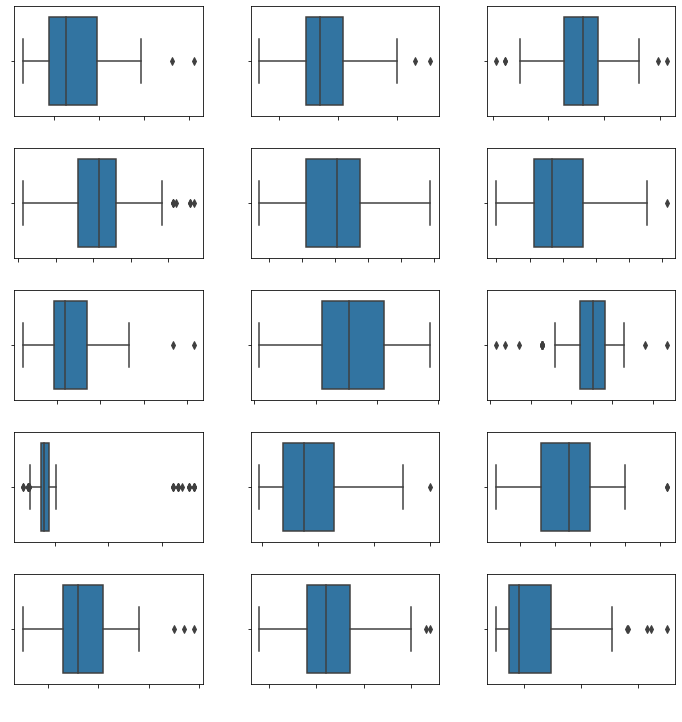

In [12]:
fig, axes = plt.subplots(5, 3, figsize=(10,10))
ax = axes.ravel()
fig.tight_layout()

for feature, i in zip(df.drop(columns=['symboling']).columns,
                      range(len(df.drop(columns=['symboling']).columns))):
    sns.boxplot(x=df[feature], ax=ax[i])

There are a few cars that are rather egregious compression-ratio outliers. Other than that no outliers seem to worry me too much. here is compression ratio vs. price. if the outlier group isnt very telling on the price then we will probably just nix it.

<AxesSubplot:xlabel='compression-ratio', ylabel='price'>

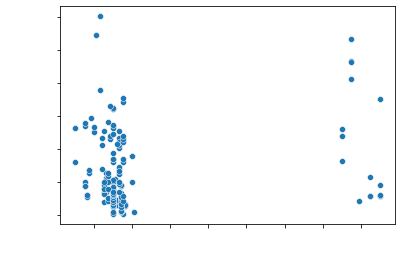

In [13]:
sns.scatterplot(x=df['compression-ratio'], y=df['price'])

we are not really getting any information from compression ratio. will probably just get rid of it. I do not know of any consumers that ask themselves 'well does the price of this vehicle justify its compression ratio??' I highly doubt marketing experts take compression ratio too much into account when determining MSRP.

<AxesSubplot:xlabel='price', ylabel='Count'>

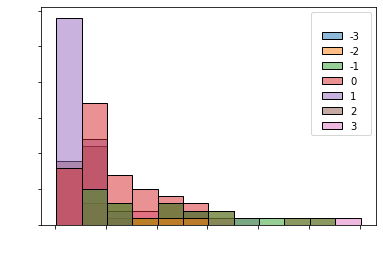

In [14]:
sns.histplot(x=df['price'], hue=df['symboling'])

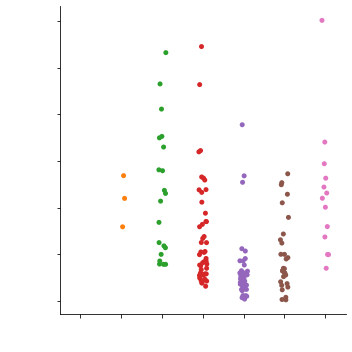

In [15]:
g = sns.catplot(x='symboling', y='price', data=df)

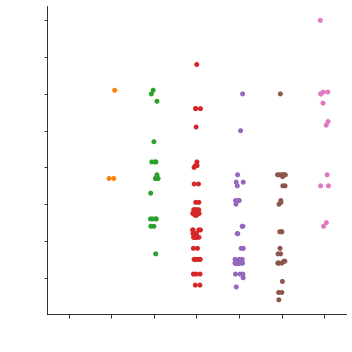

In [16]:
g = sns.catplot(x='symboling', y='horsepower', data=df)

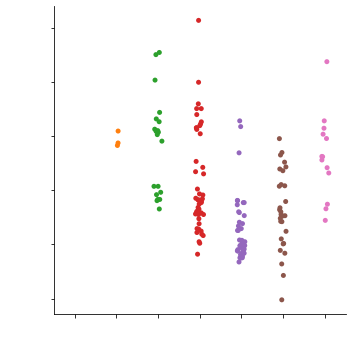

In [17]:
g = sns.catplot(x='symboling', y='curb-weight', data=df)

Curb weight and price have incredibly similar distributions when compared to symboling.

the mpg features are almost identical. maybe look at the harmonic mean or something? or just the mean?

<AxesSubplot:xlabel='city-mpg', ylabel='highway-mpg'>

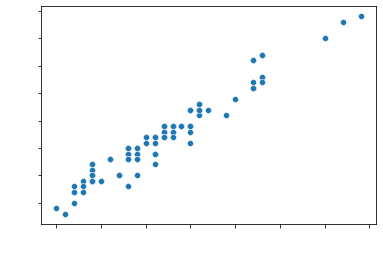

In [18]:
sns.scatterplot(x=df['city-mpg'], y=df['highway-mpg'])

In [19]:
df['mpg_mean'] = (df['city-mpg'] + df['highway-mpg'])/2

<AxesSubplot:xlabel='mpg_mean', ylabel='price'>

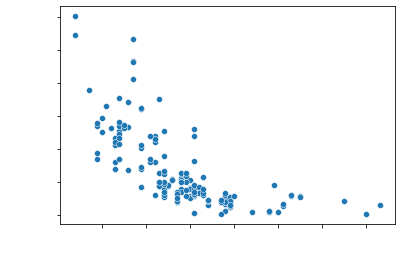

In [20]:
sns.scatterplot(x=df['mpg_mean'], y=df['price'])

In [21]:
df[['mpg_mean', 'price']].corr()

,mpg_mean,price
mpg_mean,1.000000,-0.711577
price,-0.711577,1.000000


<AxesSubplot:xlabel='mpg_mean', ylabel='price'>

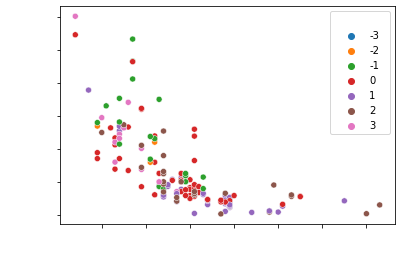

In [22]:
sns.scatterplot(x=df['mpg_mean'], y=df['price'], hue=df['symboling'])

Except for that cluster of 0's around 30 mpg and 10k theres basically no pattern. We are seeing lots of clustering here in these views though. I am starting to lean twards using trees for this model because of that.

wheelbase, curb-weight, and width all super similar.

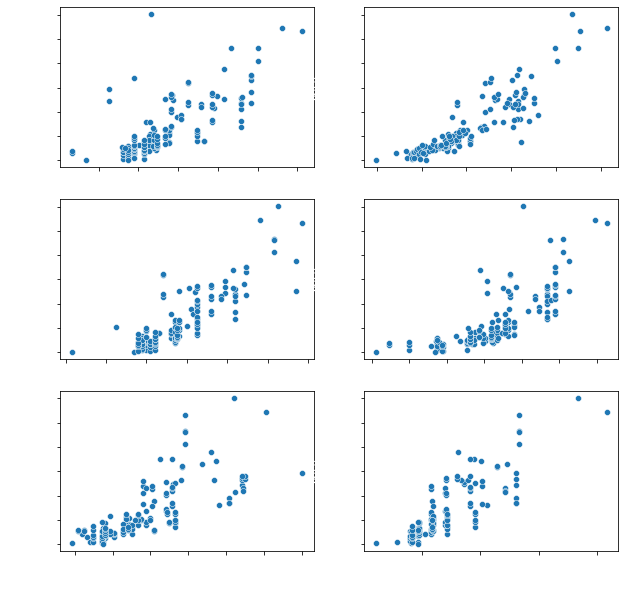

In [23]:
feats = ['wheel-base', 'curb-weight', 'width', 'length', 'horsepower', 'engine-size']
fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax = axes.ravel()

for feature, i in zip(df[feats].columns,
                      range(len(feats))):
    sns.scatterplot(x=df[feature], y=df['price'], ax=ax[i])

In [24]:
df[feats + ['price']].corr().style.background_gradient(cmap='viridis')

,wheel-base,curb-weight,width,length,horsepower,engine-size,price
wheel-base,1.000000,0.810181,0.814991,0.871534,0.516948,0.649206,0.734419
curb-weight,0.810181,1.000000,0.870595,0.871291,0.790095,0.888626,0.893639
width,0.814991,0.870595,1.000000,0.838338,0.681872,0.779253,0.843371
length,0.871534,0.871291,0.838338,1.000000,0.672063,0.725953,0.760952
horsepower,0.516948,0.790095,0.681872,0.672063,1.000000,0.812073,0.759874
engine-size,0.649206,0.888626,0.779253,0.725953,0.812073,1.000000,0.841496
price,0.734419,0.893639,0.843371,0.760952,0.759874,0.841496,1.000000


Lets see how we can combine these three to keep the same shape scatterplot and the same $R^2$ when comparing it to price

harmonic mean. higher corellation with price. notice that with this new feature we have a very very clear centroid with the moderate risk 1 cars. I wonder if these represent the budget commuter cars.

,experiment,price
experiment,1.000000,0.874919
price,0.874919,1.000000


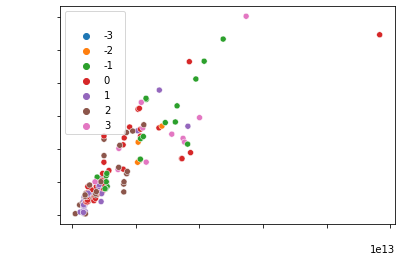

In [25]:
df['experiment'] = (df['wheel-base'] * df['curb-weight'] * df['width'] * df['length'] * \
                    df['engine-size'] * df['horsepower'])/6
sns.scatterplot(x=df['experiment'], y=df['price'], hue=df['symboling'])
df[['experiment', 'price']].corr().style.background_gradient(cmap='viridis')

arithmetic mean. more closely follows the original distributions.

,experiment,price
experiment,1.000000,0.898170
price,0.898170,1.000000


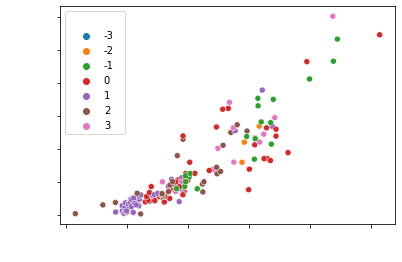

In [26]:
df['experiment'] = (df['wheel-base'] + df['curb-weight'] + df['width'] + df['length'] + \
                    df['engine-size'] + df['horsepower'])/6
sns.scatterplot(x=df['experiment'], y=df['price'], hue=df['symboling'])
df[['experiment', 'price']].corr().style.background_gradient(cmap='viridis')

Alriiight now we are gettting somewhere

In [27]:
df[['experiment', 'mpg_mean', 'price']].corr().style.background_gradient(cmap='viridis')

,experiment,mpg_mean,price
experiment,1.000000,-0.794720,0.898170
mpg_mean,-0.794720,1.000000,-0.711577
price,0.898170,-0.711577,1.000000


<AxesSubplot:xlabel='experiment', ylabel='mpg_mean'>

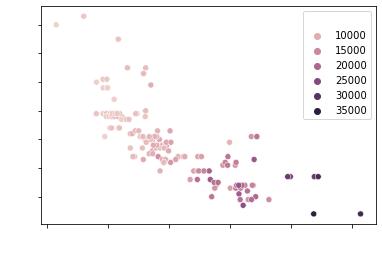

In [28]:
sns.scatterplot(x=df['experiment'], y=df['mpg_mean'], hue=df['price'])

Getting some pretty clear separation and clusters and categories and whatnot.

<AxesSubplot:xlabel='experiment', ylabel='bore'>

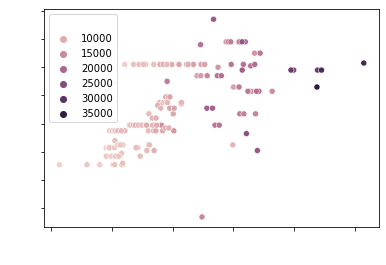

In [29]:
sns.scatterplot(x=df['experiment'], y=df['bore'], hue=df['price'])

An added bonus of these two feature engineered variables is that they are someewwwhhhaat normal. So we can just standardize them.

<AxesSubplot:xlabel='mpg_mean', ylabel='Count'>

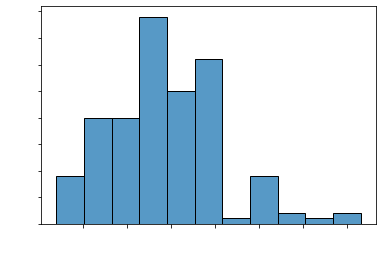

In [30]:
sns.histplot(x=df['mpg_mean'])

<AxesSubplot:xlabel='experiment', ylabel='Count'>

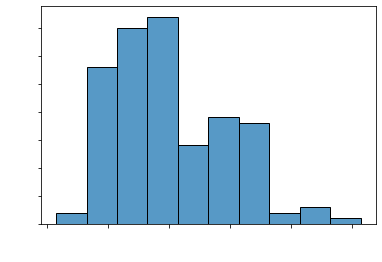

In [31]:
sns.histplot(x=df['experiment'])

<AxesSubplot:xlabel='price', ylabel='Count'>

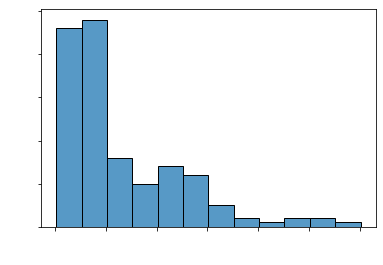

In [32]:
sns.histplot(x=df['price'])